In [ ]:
# Exploring approaches to feature engineerin and class prediction on State Department Human Rights reports

## 1 : 

In [2]:
import pandas as pd
import sqlite3 as sql

# 0 :  Define some NLP ceanin functions for later use

In [ ]:
import nltk

nltk.download('stopwords')

In [13]:
from sklearn.model_selection import train_test_split
from string import digits


import re


from nltk.corpus import stopwords
stopWords = set(stopwords.words('english'))


from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.util import ngrams

def convert(list): 
      
    # Converting integer list to string list 
    s = [str(i) for i in list] 
    
    # Join list items using join()
    s = (" ".join(s)) 
    

    return(s) 


def clean_text(s):
    
    # Convert to lowercase
    s = s.lower()
    
    # remove URLs
    s = re.sub(r"http\S+", "", s)
    
    s = s.replace('\n',' ')

    s = s.replace( "\"", '' )
    
    # Remove aposrphe
    s =s.replace("'", "")
    
    # Replace all none alphanumeric characters with spaces
    s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)

    # Repace all punctuatin with spaces
    s = re.sub(r'[^\w\s]',' ',s)

    #remove digits
    remove_digits = str.maketrans('', '', digits)
    s = s.translate(remove_digits)
    
    # remove isolated numbers (like years)
    #s = re. sub ('\b\d+\b','', s)
    
    # replace all double spaces, tabes, and returns
    s= re.sub(' +', ' ',s)
    

    
    
    
    return(s)



def stem_word(text):
    
    stemmed = []
    stemmer = LancasterStemmer()
    
    for w in text:
        stemmed.append(stemmer.stem(w))
        
    return (stemmed)


def generate_ngrams(st, n):
    
   
    # Break sentence in the token, remove empty tokens
    tokens = [token for token in s.split(" ") if token != ""]
    #tokens = remove_stops(tokens)
    #tokens = stem_word(tokens)
    
    # Use the zip function to help us generate n-grams
    # Concatentate the tokens into ngrams and return
    ngrams = zip(*[token[i:] for i in range(n)])
    return [" ".join(ngram) for ngram in ngrams]




def word_grams(words, min=1, max=4):
    s = []
    for n in range(min, max):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s


import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

def remove_location_ents(text):
    global texts_done
    texts_done  += 1
    print ("\r Analysing document  ".format(texts_done)+str(texts_done), end="")
    
    doc= nlp(text)
    drops = ['GPE','NORP','ORG','PERSON']
    GPEs = [x.text for x in doc.ents if x.label_ in drops]
    
    for word in GPEs:
        text = text.replace(word, " ")
    return text



def get_data(CIRI_Label,start,end,remove_ents=True):  #function to extract train_test_split data from DB for given CIRI label
    
    global texts_done
    global total_texts
    
    texts_done  = 1
    total_texts = 0
    
    print("Extracting Data")  
    test_df = data_df[data_df['YEAR'].between(start,end)]
    test_df = test_df[['TEXT',CIRI_Label]].dropna()
    
    states = data_df[CIRI_Label].unique()
    to_drop = [ -77.0, -66.0,-999.,-99.,-308.]
    new_states = [x for x in states if x not in to_drop]
    test_df = test_df[test_df[CIRI_Label].isin(new_states)]
    
    if remove_ents:
        print("      Removing named entities from" + str(len(test_df['TEXT'])) + " Documents")
        test_df['TEXT'] = test_df['TEXT'].apply(lambda x: remove_location_ents(x))
    
    print("      Cleaning text")
    test_df['TEXT'] = test_df['TEXT'].apply(lambda x: clean_text(x))
    
    X_train, X_test, y_train, y_test = train_test_split(test_df['TEXT'], test_df[CIRI_Label], test_size=0.3, random_state = 42)
    return( X_train, X_test, y_train, y_test)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# 1.0: Import 1a Africa Data

In [1008]:
# connect to MS_hackathon.db within the data/ directory, makes it if it doesn't exist
conn = sql.connect('../data/MS_hackathon.db')

In [1009]:
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(c.fetchall())

[('CIRI',), ('section1a_africa',), ('GapMinderData',)]


In [1010]:

c.execute('select * from section1a_africa;')
names = list(map(lambda x: x[0], c.description))
print(names)




['index', 'CountryName', 'Report']


In [1021]:
c.execute("SELECT * FROM section1a_africa;")
section_corpus = c.fetchall()
selection = pd.DataFrame(section_corpus)

selection.loc[:,2] = selection.loc[:,2].apply(lambda x: clean_text(x))


## 1.2: Clean 1a data

In [1012]:
#master_corpus = clean_text(master_corpus)
#master_corpus = remove_stops(master_corpus)


## 1.1: Vectorise 1a data

In [1013]:
from sklearn.feature_extraction.text import CountVectorizer

In [1044]:
section_corpus = convert(selection.loc[:,2])

#playing with n_gram range and max features to get a feel of what count vectoriser produces
count_vec = CountVectorizer(ngram_range=(1,2), max_features=25,stop_words = 'english')
matrix = count_vec.fit_transform([section_corpus])

count_vec_df = pd.DataFrame(matrix.toarray(), columns=count_vec.get_feature_names())
count_vec_df

,agents,agents committed,arbitrary,arbitrary unlawful,committed,committed arbitrary,force,forces,government,government agents,...,police,report,reports,reports government,rights,security,security forces,unlawful,unlawful killings,year
0,46,40,60,54,62,48,36,54,106,43,...,87,37,55,37,37,55,37,57,55,38


In [1045]:
from sklearn.feature_extraction.text import TfidfVectorizer

section_corpus = selection.loc[:,2]


tf_vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=25,stop_words = 'english')
matrix = tf_vectorizer.fit_transform(section_corpus)

tf_idf_df = pd.DataFrame(matrix.toarray(), columns=tf_vectorizer.get_feature_names())
tf_idf_df.head()

,agents,agents committed,arbitrary,arbitrary unlawful,committed,committed arbitrary,force,forces,government,government agents,...,police,report,reports,reports government,rights,security,security forces,unlawful,unlawful killings,year
0,0.078227,0.083125,0.070762,0.072192,0.073652,0.076668,0.0,0.123221,0.144383,0.079821,...,0.336298,0.272944,0.079821,0.088395,0.136472,0.000000,0.000000,0.072192,0.073652,0.739324
1,0.283448,0.301195,0.256398,0.261580,0.266871,0.277800,0.0,0.000000,0.261580,0.289225,...,0.000000,0.000000,0.289225,0.320292,0.000000,0.000000,0.000000,0.261580,0.266871,0.000000
2,0.283448,0.301195,0.256398,0.261580,0.266871,0.277800,0.0,0.000000,0.261580,0.289225,...,0.000000,0.000000,0.289225,0.320292,0.000000,0.000000,0.000000,0.261580,0.266871,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.268741,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.826397,0.297643,0.000000,0.000000,0.268741
4,0.101665,0.036010,0.122618,0.062548,0.127626,0.066426,0.0,0.053380,0.250192,0.034579,...,0.242811,0.177362,0.069159,0.038294,0.295604,0.109432,0.000000,0.093822,0.095720,0.053380


# 2.0 Trying out word clouds

In [84]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',collocations=False,
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

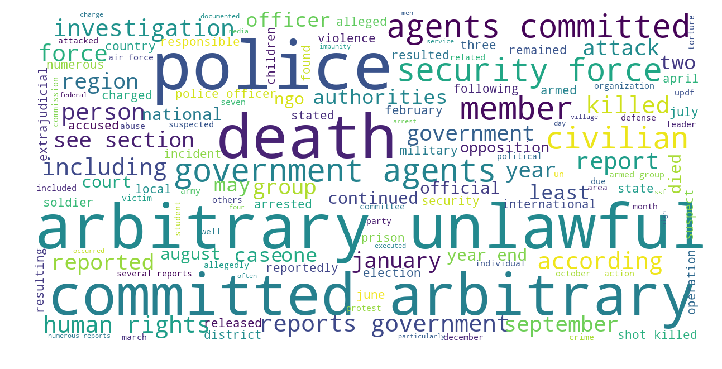

In [297]:


show_wordcloud(section_corpus)

# 3. 0: Part of Speach (POS) analysis on word 'reports'

## 3.1 Import 2018 all of africa reports

In [621]:
# import all text for Africa

text_folder = '../data/Custom_State_Dep_Reports/'

with open(text_folder+'2018_all_sections_africa.txt', 'r') as myfile:
  master_corpus = myfile.read()


In [739]:
# covert sentences into list items
text = master_corpus.replace('\n',' ') 
text =text.split('.')
text = [clean_text(i) for i in text]

# creat list of sentences with 'reports' mentioned
subs='reports'
res = [i for i in text if subs in i]
len(res)

1116

In [662]:
# download some additional nltk packages
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/garethwalker/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

## 3.2: Try analysing sentences with 'reports'

In [1046]:



def return_qualifiers(sentence2,scan_breadth):
    
    # Tokenise sentence
    tokens = nltk.word_tokenize(sentence2)
    POS_data   = nltk.pos_tag(tokens)
    
    
    # Determin words prior to keyword to sample
    keyword_position = tokens.index('reports')
    scan_breadth       = max(0, keyword_position-scan_breadth)
    words_prior      = POS_data[scan_breadth:keyword_position]

    #search through these words for verbs, adjectives and determiners which qualify keyword
    
    POS_before=['RB','EX','VBN','VBD','DT','JJ','NN','NNS','according'] # civil soc orgs; also see https://www.clips.uantwerpen.be/pages/mbsp-tags
    result=[]
    for j in POS_before:
        match = [i for i in words_prior if j in i]
        result.append(match)
    
    # an addional search for verbs after reports (reports indicated, reports confired)
    
    verb_list = ['VB','VBN','VBZ','VBD']
    
    for verb in verb_list:   
        try:
            if POS_data[keyword_position+1][1] == verb:
                result.append(POS_data[keyword_position+1])
        except:
            pass
  

    return(result)

#VBD,VB
#print(Before_report)
#print(POS_data)


def return_details(sentence,scan_breadth):
    # Tokenise sentence
    tokens = nltk.word_tokenize(sentence)
    POS_data   = nltk.pos_tag(tokens)
    
    # Determin words after keyword to sample
    #keyword_position = tokens.index('reports')
    #scan_breadth = min(len(POS_data),keyword_position+scan_breadth)
    #words_after = POS_data[keyword_position+1:scan_breadth]

    # scan forwards for nouns NN, NNS, and Adjectives JJ and verbs VB VBD to describe report content
    POS_after=['NN','NNS','JJ','VBD','VBG'] # see see https://www.clips.uantwerpen.be/pages/mbsp-tags
    result=[]
    for j in POS_after:
        match = [i for i in POS_data if j in i]
        result.append(match)
    return(result)

print(return_qualifiers(res[1002],4))

print(return_details(res[1002],15))



[[], [], [], [('received', 'VBD')], [], [('regular', 'JJ')], [], [], []]
[[('expert', 'NN'), ('situation', 'NN'), ('sudan', 'NN'), ('s', 'NN'), ('section', 'NN'), ('rape', 'NN'), ('gender', 'NN'), ('violence', 'NN'), ('see', 'NN'), ('section', 'NN')], [('rights', 'NNS'), ('rights', 'NNS'), ('reports', 'NNS'), ('incidents', 'NNS')], [('international', 'JJ'), ('human', 'JJ'), ('unamid', 'JJ'), ('human', 'JJ'), ('regular', 'JJ'), ('sexual', 'JJ')], [('reported', 'VBD'), ('received', 'VBD')], []]


# 4.0 Use SVM to classify text

### Import neccesary packages

In [5]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
import seaborn as sn


### Define functions to measure performance

In [6]:


def performance_report(df, CIRI_label):
    df= df[df['Class']==CIRI_label]
    print('accuracy %s' % accuracy_score(df['y_pred'], df['y_test']))
    print(classification_report(df['y_test'],df['y_pred']))
    print(confusion_matrix(df['y_test'],df['y_pred']))
    
def generate_performance_db(df):
    labels = df['Class'].unique()
    df_performance =pd.DataFrame(columns = ['Class','Accuracy','Precision','Recall'])
    
    for i in range(len(labels)):
        label = labels[i]     
        df_of_int= df[df['Class']==label]
        
        df_performance.loc[i,'Class']     =  str(label)
        df_performance.loc[i,'Accuracy']  =  accuracy_score(df_of_int['y_pred'], df_of_int['y_test'])
        df_performance.loc[i,'Precision'] =  precision_score(df_of_int['y_pred'], df_of_int['y_test'],average='micro')
        df_performance.loc[i,'Recall']    =  recall_score(df_of_int['y_test'],df_of_int['y_pred'],average='micro')
        
    return df_performance

### Define piplines to explore different models approaches

In [131]:



sgd = Pipeline([('vect', CountVectorizer()),('model', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=30, tol=None)),])

sgd_ngrams = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None)), #alpha=1e-3,
               ])

sgd_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', SGDClassifier(class_weight = 'balanced', loss='hinge', penalty='l2', random_state=42, max_iter=30, tol=None)), #alpha=1e-3,
               ])

svm = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english')),
                ('model', LinearSVC(class_weight='balanced')),])


svm_ngrams = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('model', LinearSVC(class_weight='balanced')),])


svm_ngrams_tfidf = Pipeline([('vect', CountVectorizer(strip_accents= 'unicode', stop_words='english',ngram_range=(1,2))),
                ('tfidf', TfidfTransformer()),
                ('model', LinearSVC(class_weight='balanced')),])


## 4.1 Use SGD to classify reports vs no reports

Using some labeled data I put together manually, this classfies sentences with 'reports' in the sentence as positive or negaitve

### 4.1.1 Import labled training data and all of africa 2018 text

In [8]:

training_df=pd.read_csv('../data/NLP_training_set.csv')
training_df = training_df.drop(columns=['Unnamed: 0'])
training_df['Basic_Class']=training_df['Class']
training_df['Basic_Class'].replace(1,0,inplace=True)
training_df['Basic_Class'].replace(2,1,inplace=True)
training_df['Basic_Class'].replace(3,1,inplace=True)


FileNotFoundError: [Errno 2] File b'../data/NLP_training_set.csv' does not exist: b'../data/NLP_training_set.csv'

### 4.1.2 Apply SVM classifier

In [797]:
X = training_df['String']
y = training_df['Basic_Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)


### 4.1.3 Evaluate SVM classifier

In [795]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy 0.9373134328358209
              precision    recall  f1-score   support

           0       0.95      0.92      0.93       164
           1       0.93      0.95      0.94       171

   micro avg       0.94      0.94      0.94       335
   macro avg       0.94      0.94      0.94       335
weighted avg       0.94      0.94      0.94       335

[[151  13]
 [  8 163]]


## 4.2 Use SVM to predict report section membership (hence type of offence)

now that Marie has pacred the africa section, I can look at how SVM performs on recognising types of transgessions

In [127]:
df_all_africa = pd.read_csv('../data/Custom_State_Dep_Reports/2018_all_sections_africa_PARCED.csv')

In [89]:
df_train=pd.DataFrame(columns=['text','label'])

for i in range(len(df_all_africa.columns)-3): 
    df_extract = pd.DataFrame(columns=['text','label'])
    df_all_africa.iloc[:,i+3] = df_all_africa.iloc[:,i+3].astype(str)
    df_extract['text']=' '.join(df_all_africa.iloc[:,i+3]).replace('\n',' ').split('.')
    df_extract['label'] = df_all_africa.columns[i+3]
    df_train= df_train.append(df_extract)


In [90]:
X = df_train['text']
y = df_train['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

In [91]:
sgd.fit(X_train, y_train)
y_pred = sgd.predict(X_test)

### 4.2.1: Evaluate model

In [92]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))

accuracy 0.7305077968812475
              precision    recall  f1-score   support

  Section_1a       0.59      0.27      0.37       125
  Section_1b       0.71      0.37      0.49        59
  Section_1c       0.79      0.75      0.77       657
  Section_1d       0.69      0.66      0.67       678
  Section_1e       0.69      0.69      0.69       530
  Section_1f       0.63      0.41      0.50        93
  Section_1g       0.51      0.36      0.42       139
  Section_2a       0.77      0.81      0.79       512
  Section_2b       0.64      0.55      0.59       175
  Section_2c       0.78      0.63      0.70        51
  Section_2d       0.82      0.76      0.79       455
   Section_3       0.71      0.76      0.74       394
   Section_4       0.75      0.71      0.73       263
   Section_5       0.62      0.53      0.58       187
   Section_6       0.70      0.89      0.79      1668
  Section_7a       0.86      0.84      0.85       432
  Section_7b       0.63      0.41      0.50       188

Performs better on some cataories than others, this is without text cleaning or parameter tuning, so it feels promissing

####  testing on classifying sections of Amnesty International

In [97]:
test = "Reports of domestic violence increased; immediate protection orders had been issued by 1 June. In August, Judge Fildeze Hafizi was shot and killed in her car by her former husband. She had been granted a protection order in 2015 after he had beaten her. He was convicted and imprisoned in April 2016, but released in early 2017 under a general amnesty."
test = test.split('.')
y_pred = sgd.predict(test)
y_pred

array(['Section_6', 'Section_6', 'Section_1d', 'Section_1d', 'Section_6'],
      dtype='<U10')

In [94]:
test2 = 'Physical attacks against investigative journalists were perpetrated by organized criminals, or owners of private companies. In March, journalist Elvi Fundo was beaten in the capital, Tirana, by assailants believed to be associated with organized crime. In June, TV channel owner Erven Hyseni was shot dead in Vlora, along with a government official. In July, journalists claimed that defamation proceedings brought against two media outlets by High Court Judge Gjin Gjoni and his wife, businesswoman Elona Caushi, aimed to intimidate investigative journalists and encourage self-censorship.'
test2 = test2.split('.')
y_pred = sgd.predict(test2)
y_pred

array(['Section_2a', 'Section_2a', 'Section_2a', 'Section_2a',
       'Section_6'], dtype='<U10')

In [95]:
test3 = 'No measures were taken to locate the body of Remzi Hoxha, a Macedonian Albanian who was forcibly disappeared by National Intelligence Service officials in 1995. No progress was reported towards the exhumation of the remains of around 6,000 people who had disappeared between 1945 and 1991.'
test3 = test3.split('.')
y_pred = sgd.predict(test3)
y_pred

array(['Section_1b', 'Section_6', 'Section_6'], dtype='<U10')

In [96]:
test4 = 'Measures to ensure judicial independence were partially implemented. In June, two judicial associations appealed to the Constitutional Court against a vetting law, which sought to ensure judges’ and prosecutors’ independence from organized crime.'
test4 = test4.split('.')
y_pred = sgd.predict(test4)
y_pred

array(['Section_1e', 'Section_1e', 'Section_6'], dtype='<U10')

# 4. 3 Using SVM to predict CIRI scores

In [9]:
data_df = pd.read_csv('../data/Custom_State_Dep_Reports/CIRI_Text_1999_2015.csv')
data_df.columns = map(lambda x: str(x).upper(), data_df.columns)

state_dep = pd.read_csv('../data/Custom_State_Dep_Reports/us_state_dept_reports_1999_2018.csv')
state_dep.columns = map(lambda x: str(x).upper(), state_dep.columns)             

In [10]:
predict_df = state_dep[state_dep['YEAR'].between(2016,2018)]
predict_df = predict_df[['TEXT','YEAR','COUNTRY']]


In [11]:
data_df.columns

Index(['UNNAMED: 0', 'YEAR', 'COUNTRY', 'URL', 'TEXT', 'CODE', 'UNCTRY',
       'COUNTRYNAME', 'CIRI', 'COW', 'POLITY', 'UNCTRY', 'UNREG', 'UNSUBREG',
       'KILL', 'DISAP', 'TORT', 'POLPRIS', 'SPEECH', 'NEW_RELFRE', 'DOMMOV',
       'FORMOV', 'ASSN', 'ELECSD', 'WORKER', 'WOPOL', 'WECON', 'INJUD',
       'PHYSINT', 'NEW_EMPINX', 'UNNAMED: 24', 'UNNAMED: 25'],
      dtype='object')

In [178]:
CIRI_Labels_Predict = ['KILL', 'DISAP', 'TORT', 'POLPRIS', 'SPEECH', 'NEW_RELFRE', 'DOMMOV',
       'FORMOV', 'ASSN', 'ELECSD', 'WORKER', 'WOPOL', 'WECON', 'INJUD',
       'PHYSINT', 'NEW_EMPINX']

#['PHYSINT', 'DISAP','KILL', 'POLPRIS', 'TORT', 'OLD_EMPINX', 'NEW_EMPINX', 'ASSN', 'FORMOV','DOMMOV', 'OLD_MOVE', 'SPEECH', 'ELECSD', 'OLD_RELFRE', 'NEW_RELFRE','WORKER', 'WECON', 'WOPOL', 'WOSOC', 'INJUD']

df_model_perform = pd.DataFrame(columns =['Class','y_test','y_pred'])
df_model_features = pd.DataFrame(columns =['Class'])
df_model_projections = pd.DataFrame(columns = ['Country','CIRI_LABEL','Prediction'])


selected_model = svm_ngrams
top_features = 20


for C_label in CIRI_Labels_Predict[0:2]:
    
    print('Analysing: ' + str(C_label))
    

    df_code_perform  = pd.DataFrame(columns =['Class','y_test','y_pred'])
    df_code_features = pd.DataFrame(columns =['Class'])

    X_train, X_test, y_train, y_test= get_data(C_label,2000,2015, False)
    print('   Fitting model')
    x = selected_model.fit(X_train, y_train)
    y_pred = selected_model.predict(X_test)
    
    #Report model performance
    print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test,y_pred))
    
    
    # Extract feature names
    feature_names = [selected_model.named_steps['vect'].get_feature_names()]
    feature_names = np.array(feature_names)
    
    # Extract coefficients and return t
    for label in range(y_train.nunique()):
        coefs =  [selected_model.named_steps['model'].coef_[label].ravel()]
        top_coef_index = np.argsort(coefs)[0][-top_features:]
        top_words = feature_names[0][top_coef_index] 
        top_coef_values = coefs[0][top_coef_index]
        df_code_features['Top words '+str(label)] = top_words
        df_code_features['Top word coefs '+str(label)] = top_coef_values
    
    df_code_features['Class'] = str(C_label)
    
    # Extract model performance data
    df_code_perform['y_test'] =  y_test
    df_code_perform['y_pred'] = y_pred
    df_code_perform['Class'] = str(C_label)
    

    #record model performance and features for this CIRI label
    df_model_perform = df_model_perform.append(df_code_perform)
    df_model_features = df_model_features.append(df_code_features)
    
    #Making predictions for 2016-2018:
    print('   Classifying 2016-2018 texts')
    predict_df['TEXT'] = predict_df['TEXT'].apply(lambda x: clean_text(x))
    predict_df[C_label] = selected_model.predict(predict_df['TEXT'])

    
    

Analysing: KILL
Extracting Data
      Cleaning text
   Fitting model
   Accuracy: 0.7965909090909091
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80       157
         1.0       0.69      0.70      0.69       284
         2.0       0.86      0.86      0.86       439

   micro avg       0.80      0.80      0.80       880
   macro avg       0.79      0.78      0.79       880
weighted avg       0.80      0.80      0.80       880

[[123  31   3]
 [ 25 199  60]
 [  1  59 379]]
   Classifying 2016-2018 texts
Analysing: DISAP
Extracting Data
      Cleaning text
   Fitting model
   Accuracy: 0.8920454545454546
              precision    recall  f1-score   support

         0.0       0.74      0.64      0.69        50
         1.0       0.58      0.56      0.57       101
         2.0       0.94      0.95      0.95       729

   micro avg       0.89      0.89      0.89       880
   macro avg       0.75      0.72      0.74       880
weighted avg 

In [179]:
predict_df.to_csv('../data/SVM_Predictions.csv')
df_model_features.to_csv('../data/SVM_Features.csv')
df_model_perform.to_csv('../data/SVM_Performance.csv')

# Generate word cloud for cluster

In [175]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt



def return_cluster_words(List_Tup): # recieves a list of tuples giving CIRI lable and respective score
    cluster_df = pd.DataFrame(columns=['Top_words','Top_words_coefs','CIRI_label'])
    top_features =20

    for tup in List_Tup:
        ciri_label = tup[0]
        score= tup[1]
        
        df_class = df_model_features[df_model_features['Class']==ciri_label]

        # lookup top words and coefs
        #top_coefs = coefs[top_positive_coefficients]
        #feature_names = np.array(feature_names)
        #top_words = feature_names[top_positive_coefficients]
        
        # export to DF
        tup_df = pd.DataFrame()
        
        tup_df['Top_words']=df_class['Top words '+str(score)]
        tup_df['Top_words_coefs']=df_class['Top word coefs '+str(score)]
        
        tup_df['CIRI_label']=ciri_label
        cluster_df = cluster_df.append(tup_df)
        cluster_df.reset_index(inplace=True)
    return cluster_df

def generate_cloud_text(df):
    
    for i in range(len(df.index)):
        df.loc[i,'Wieghted_string'] = (df.loc[i,'Top_words']+' ') * int(df.loc[i,'Top_words_coefs']*10000)

    output = df['Wieghted_string'].str.cat(sep=' ')
    return output


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        collocations=False,
        #stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(10, 30))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
def cluster_word_cloud(List_Tup):
    cluster_df = return_cluster_words(List_Tup)
    wieghted_text = generate_cloud_text(cluster_df)
    show_wordcloud(wieghted_text)

In [177]:
test_list =[('KILL',0),('DISAP',0)]
cluster_word_cloud(test_list)

KeyError: 'Top words 0'

In [188]:
performance = generate_performance_db(df_model_perform)

[Text(0, 0, 'DISAP')]

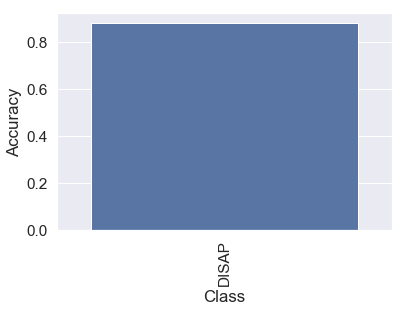

In [228]:
from seaborn import barplot

performance = generate_performance_db(df_model_perform)

results = barplot(x=performance['Class'],y=performance['Accuracy'])
results.set_xticklabels(results.get_xticklabels(), rotation=90)

In [1146]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))




accuracy 0.7929824561403509
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.78       127
         1.0       0.65      0.75      0.70       172
         2.0       0.89      0.84      0.86       271

   micro avg       0.79      0.79      0.79       570
   macro avg       0.79      0.78      0.78       570
weighted avg       0.80      0.79      0.80       570

[[ 95  31   1]
 [ 15 129  28]
 [  6  37 228]]


### Plot performance matrix for PHYSINT



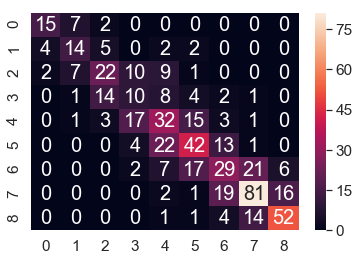

In [1252]:

df= df_model_perform[df_model_perform['Class']=='PHYSINT']
array = confusion_matrix(df['y_test'],df['y_pred'])
df_cm = pd.DataFrame(array, range(9),
                  range(9))
#plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 20})# font size





# Extracting feature importance from SGD

In [110]:

def plot_coefficients(classifier, feature_names, top_features=20):
    coef = classifier.coef_[0].ravel()  # I think you need to index for each class within the lable
    
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    #print('Top Positive Coefficients: ' + str(top_positive_coefficients))
    
    top_negative_coefficients = np.argsort(coef)[:top_features]
    #print('Top Negative Coefficients: ' + str(top_negative_coefficients))
    
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]] 
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    #print('Feature Names: ' + str(feature_names))
    plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    

def fit_model_report_features(pipe):
    
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    feature_names = pipe.named_steps['vect'].get_feature_names()
    model = pipe.named_steps['model']

    plot_coefficients(model, feature_names)
    print('   Accuracy: %s' % accuracy_score(y_pred, y_test))
    

## Using and example of free speech indicator

In [140]:
X_train, X_test, y_train, y_test= get_data('SPEECH',1999,2009, False)

   Extracting Data
      Cleaning text


#### Basic SVM

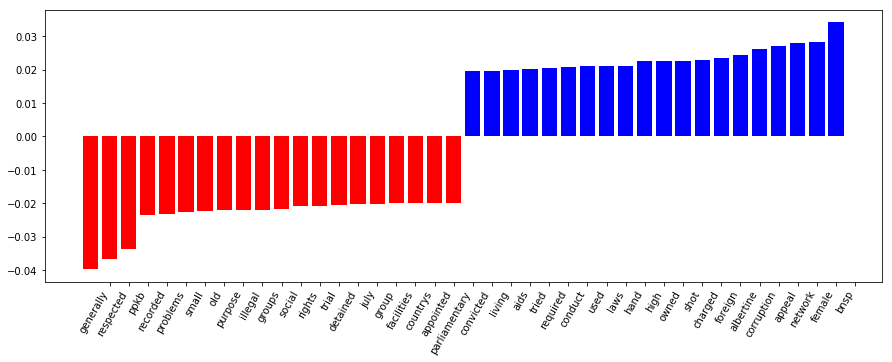

   Accuracy: 0.7585616438356164


In [141]:
fit_model_report_features(svm)

#### SVM with ngrams

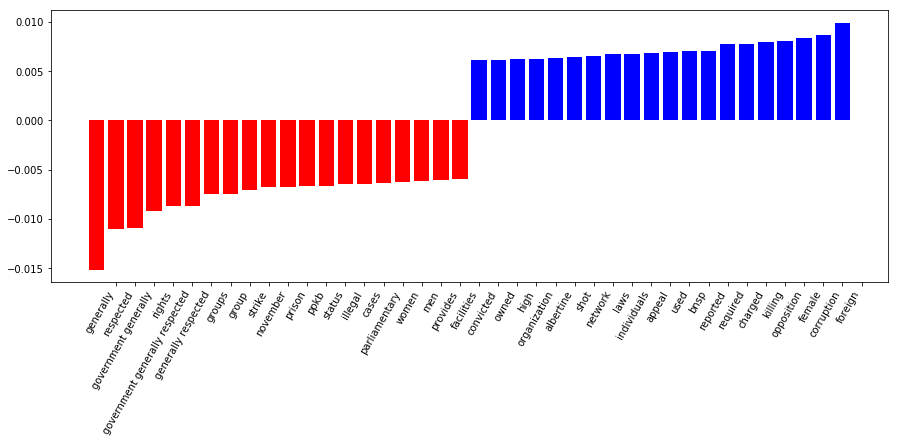

   Accuracy: 0.7688356164383562


In [167]:
fit_model_report_features(svm_ngrams)

#### SVM with ngrams and tfidf

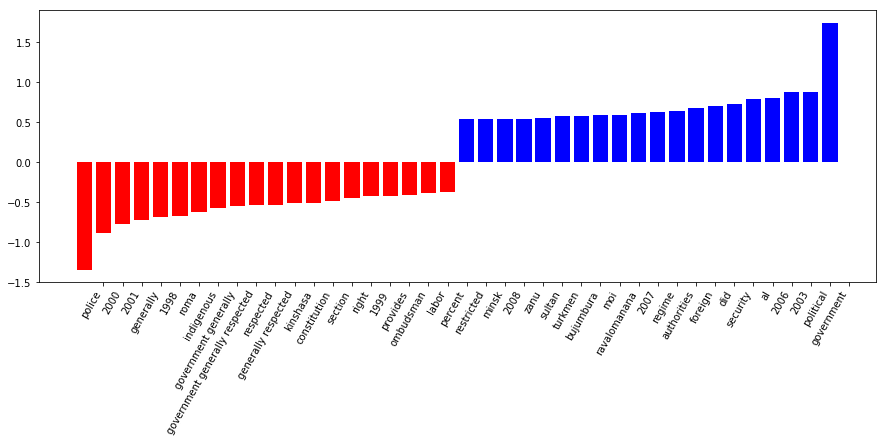

   Accuracy: 0.7964912280701755


In [119]:
fit_model_report_features(svm_ngrams_tfidf)

#### SGD no ngrams or tf idf

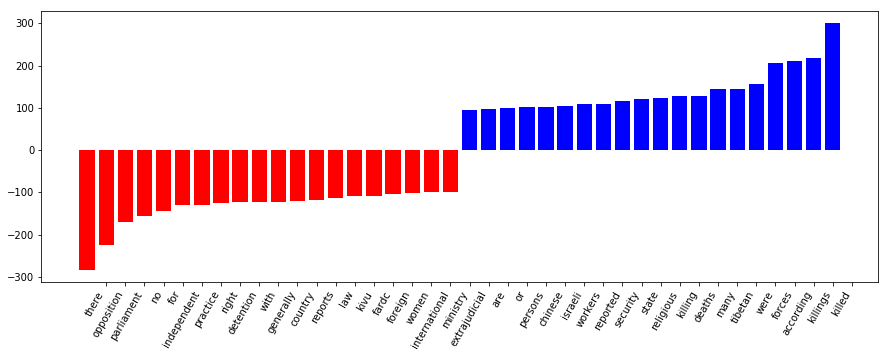

   Accuracy: 0.6526315789473685


In [124]:
fit_model_report_features(sgd)


### Try example 'KILL'

In [120]:
X_train, X_test, y_train, y_test= get_data('KILL',1999,2009, False)

   Extracting Data
      Cleaning text


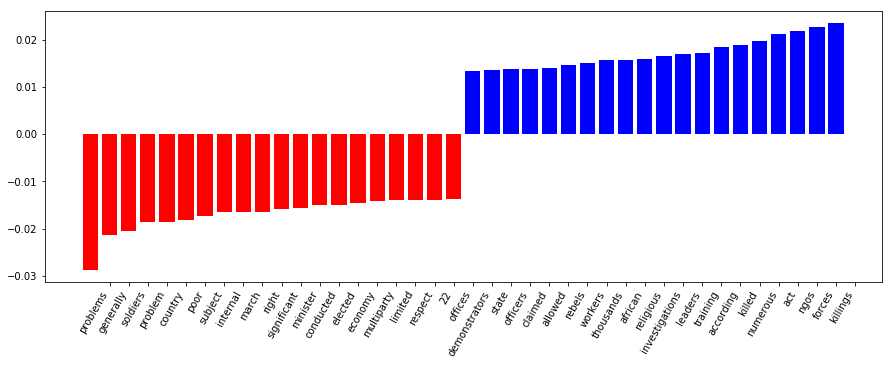

   Accuracy: 0.7596491228070176


In [125]:
fit_model_report_features(svm)

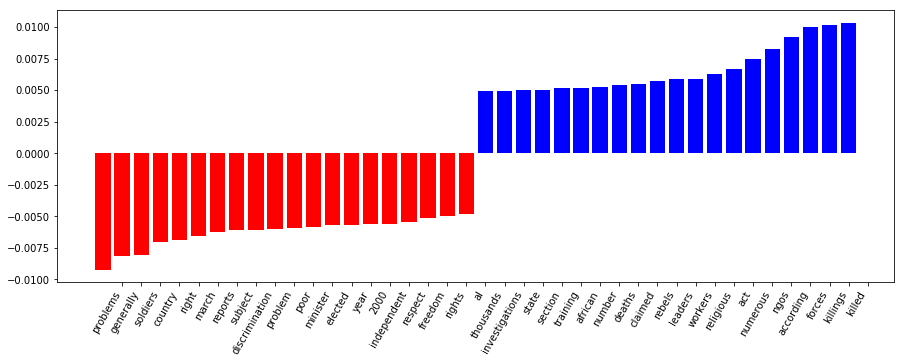

   Accuracy: 0.7614035087719299


In [126]:
fit_model_report_features(svm_ngrams)

looks like location based data is playing too much of a role in analysis

,Class,feature_names,feature_coefs
0,NaN,00,0.000064
1,NaN,00 00,-0.000039
2,NaN,00 00 authorities,0.000000
3,NaN,00 00 balboa,0.000000
4,NaN,00 00 balboas,0.000000
5,NaN,00 00 bring,0.000000
6,NaN,00 00 day,0.000000
7,NaN,00 00 desire,0.000000
8,NaN,00 00 employers,-0.000072
9,NaN,00 00 hour,0.000000
